# 데이터 프로세싱 및 피쳐 추가
Feature -- Processing & EDA & Engineering 용도

In [7]:
#----------------------------------
# 1. 데이터 로드 및 데이터 개수 파악
#---------------------------------

import pandas as pd

# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Data/train.csv')

# generated 컬럼이 0인 행의 개수 조사
human_count = (df['generated'] == 0).sum()
ai_count = (df['generated'] == 1).sum()

print(f"사람이 작성한 글(generated=0)의 개수: {human_count}개")
print(f"AI가 일부작성한 글(generated=1)의 개수: {ai_count}개")

사람이 작성한 글(generated=0)의 개수: 89177개
AI가 일부작성한 글(generated=1)의 개수: 7995개


In [8]:
#----------------------------------
# 2. 문단 수 분석 및 이상치 제거
# 모든 행(df)에 대해 문단 수를 카운팅하고, AI와 인간 각각의 통계치를 비교한 뒤 상위 10% 지점에서 데이터를 절단합니다.
#---------------------------------

import pandas as pd
import numpy as np
import re

def extract_advanced_features(df):
    # 1. 문장 단위 분석 함수
    def get_sentence_metrics(text):
        # 문장 분리 (마침표, 물음표, 느낌표 기준)
        sentences = re.split(r'[.!?]+', str(text))
        sentences = [s.strip() for s in sentences if len(s.strip()) > 0]

        if not sentences:
            return 0.0, 0.0, 0.0

        # 각 문장별 단어 수 측정
        lens = [len(s.split()) for s in sentences]

        # 중앙값, 상위 10%, 표준편차 계산
        len_median = np.median(lens)
        len_p90 = np.percentile(lens, 90)
        len_std = np.std(lens)

        return median_len, p90_len, std_len

    print("문장 길이 지표(중앙값, 상위10%, 표준편차)")
    sent_metrics = df['full_text'].apply(get_sentence_metrics)
    df['sent_len_median'] = sent_metrics.apply(lambda x: x[0])
    df['sent_len_p90'] = sent_metrics.apply(lambda x: x[1])
    df['sent_len_std'] = sent_metrics.apply(lambda x: x[2])

    print("구두점(쉼표) 밀도 및 띄어쓰기 패턴")
    # 구두점 밀도 정의: 쉼표 개수 / (문체 글자수 / 100)
    # 글자수가 0인 경우를 대비해 아주 작은 값(1e-6)을 더해 나눕니다.
    df['comma_density'] = df['full_text'].apply(
        lambda x: (str(x).count(',') / (len(str(x)) / 100)) if len(str(x)) > 0 else 0
    )


# [n_paragraphs 컬럼 생성] - 정규식을 사용하여 실제 텍스트 덩어리 개수 파악
def count_paragraphs(text):
    if pd.isna(text): return 1
    paragraphs = [p.strip() for p in re.split(r'\n+', text) if p.strip()]
    return len(paragraphs)

df['n_paragraphs'] = df['full_text'].apply(count_paragraphs)


# [기초통계량 조사] - 인간(0)과 AI(1) 각각 분석
df_human = df[df['generated'] == 0]
df_ai = df[df['generated'] == 1]

print("\n=== [인간 작성 데이터(gen=0)] 문단 수 통계 ===")
print(df_human['n_paragraphs'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

print("\n=== [AI 작성 데이터(gen=1)] 문단 수 통계 ===")
print(df_ai['n_paragraphs'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


# [이상치 제거] - n_paragraphs 상위 10% (90th percentile) 값을 기준점으로 설정
upper_limit = df_human['n_paragraphs'].quantile(0.90)
# 1. 조건에 맞는 '인간 데이터'만 따로 정의 (에러 해결 핵심)
df_human_cleaned = df_human[
    (df_human['n_paragraphs'] >= 2) &
    (df_human['n_paragraphs'] <= upper_limit)
].copy()
# 2. 전체 df 갱신 (정제된 인간 데이터 + 기존 AI 데이터)
df = pd.concat([
    df_human_cleaned,           # 정제된 gen=0
    df[df['generated'] == 1]    # gen=1
]).reset_index(drop=True)
# 3. 결과 출력
print(f"\n[이상치 제거 결과]")
print(f"설정된 상한선(상위 10%): {upper_limit} 개")
# 이제 df_human_cleaned가 정의되어 있으므로 에러 없이 출력됩니다.
print(f"제거 전(gen=0): {len(df_human)}개 -> 제거 후(gen=0): {len(df_human_cleaned)}개")
print(f"삭제된 데이터 수: {len(df_human) - len(df_human_cleaned)}개")


=== [인간 작성 데이터(gen=0)] 문단 수 통계 ===
count    89177.000000
mean        12.622672
std         17.040229
min          1.000000
25%          6.000000
50%          8.000000
75%         14.000000
90%         24.000000
95%         35.000000
99%         73.000000
max       1729.000000
Name: n_paragraphs, dtype: float64

=== [AI 작성 데이터(gen=1)] 문단 수 통계 ===
count    7995.000000
mean       12.596873
std        14.742438
min         1.000000
25%         6.000000
50%         8.000000
75%        14.000000
90%        24.000000
95%        35.000000
99%        77.120000
max       320.000000
Name: n_paragraphs, dtype: float64

[이상치 제거 결과]
설정된 상한선(상위 10%): 24.0 개
제거 전(gen=0): 89177개 -> 제거 후(gen=0): 80164개
삭제된 데이터 수: 9013개


In [9]:
#----------------------------------
# 3. 군집화 및 층화 샘플링
# 정제된 데이터를 바탕으로 주제별 군집을 나누고, 편향성을 최소화하여 최종 학습용 데이터를 추출합니다.
#---------------------------------


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

# 군집화를 위해 인간 데이터만 별도 추출
df_human_cleaned = df[df['generated'] == 0].copy()
df_ai_cleaned = df[df['generated'] == 1].copy()

# [단계 설명]
# 1. max_features: TF-IDF 벡터화 시 가장 중요한 단어 1,000개만 피처값으로 사용 (속도와 메모리 효율)
# 2. MiniBatchKMeans: 대용량 데이터를 빠르게 처리하기 위해 배치 단위로 군집화 수행
# 3. n_clusters: 데이터를 10개의 서로 다른 주제(도메인) 클러스터값으로 분류
# 4. random_state: 코드 실행 시마다 동일한 군집 결과가 나오도록 랜덤스테이트값 고정

tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.95)
tfidf_matrix = tfidf.fit_transform(df_human_cleaned['full_text'].fillna(''))

kmeans = MiniBatchKMeans(n_clusters=10, batch_size=1000, random_state=42)
df_human_cleaned['cluster'] = kmeans.fit_predict(tfidf_matrix)

# [최종 샘플링] 인간 데이터를 AI 데이터의 3배수로 추출
target_n = len(df_ai_cleaned) * 3
sample_rate = target_n / len(df_human_cleaned)

final_human_sample = df_human_cleaned.groupby('cluster', group_keys=False).apply(
    lambda x: x.sample(frac=sample_rate, random_state=42)
).head(target_n)

# 결과 저장
gen2_tasks = final_human_sample[['title', 'n_paragraphs']]
gen2_tasks.to_csv('/content/drive/MyDrive/Data/gen2_tasks_final.csv', index=False)
final_human_sample.drop(columns=['cluster']).to_csv('/content/drive/MyDrive/Data/train_human_3x.csv', index=False)

print(f"\n[최종 완료] gen=2 생성 태스크 리스트 저장 완료: {len(gen2_tasks)}행")

/tmp/ipython-input-421187371.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_human_sample = df_human_cleaned.groupby('cluster', group_keys=False).apply(



[최종 완료] gen=2 생성 태스크 리스트 저장 완료: 23984행


##원본데이터(gen=0,1) 추출 및 gen = 2 생성

### 0~1. doc_id 추가 및 df1 구성 (gen=0: 6천개, gen=1: 2천개)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

# 0. 고유 ID 부여
df['doc_id'] = [f"DOC_{i:06d}" for i in range(len(df))]

# 데이터 분리
df_human_all = df[df['generated'] == 0].copy()
df_ai_all = df[df['generated'] == 1].copy()

# 1. gen=0 (6천개) & gen=1 (2천개) 편향성 최소화 샘플링
def get_stratified_sample(df_sub, target_n):
    tfidf = TfidfVectorizer(max_features=512, min_df=5, max_df=0.95)
    tfidf_matrix = tfidf.fit_transform(df_sub['full_text'].fillna(''))
    kmeans = MiniBatchKMeans(n_clusters=10, random_state=42)
    df_sub['cluster'] = kmeans.fit_predict(tfidf_matrix)

    # 군집별 비중에 맞춰 target_n만큼 샘플링
    sample = df_sub.groupby('cluster', group_keys=False).apply(
        lambda x: x.sample(n=int(len(x)/len(df_sub)*target_n), random_state=42)
    )
    # 반올림 오차 보정
    if len(sample) < target_n:
        extra = df_sub.loc[df_sub.index.difference(sample.index)].sample(target_n - len(sample))
        sample = pd.concat([sample, extra])
    return sample.head(target_n).drop(columns=['cluster'])

df_human_6k = get_stratified_sample(df_human_all, 6000)
df_ai_2k = get_stratified_sample(df_ai_all, 2000)

# 최종 df1 (8천개)
df1 = pd.concat([df_human_6k, df_ai_2k]).reset_index(drop=True)

/tmp/ipython-input-4151329809.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = df_sub.groupby('cluster', group_keys=False).apply(
/tmp/ipython-input-4151329809.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = df_sub.groupby('cluster', group_keys=False).apply(


### 2. df2 구성 (gen=2 생성을 위한 2천개 추출)

In [11]:
# df1의 gen=0(6천개) 중에서 2천개 샘플링
# 이미 df_human_6k 자체가 편향이 최소화된 상태이므로 여기서 무작위 2천개를 추출합니다.
df_human_for_gen2 = df_human_6k.sample(n=2000, random_state=42).copy()

# df2 구성: gen=2로 라벨링, full_text는 공백
df2 = pd.DataFrame({
    'doc_id': df_human_for_gen2['doc_id'],
    'title': df_human_for_gen2['title'],
    'full_text': "", # 나중에 채워질 공간
    'generated': 2,
    'n_paragraphs': df_human_for_gen2['n_paragraphs'] # 원본 문단 수 참조용
})

### 3. LLM 구축 및 테스트, df2 업데이트

In [13]:
# LLM 1단계: 코랩에 Ollama 엔진 설치 및 서버 실행

# 1. 시스템 의존성 설치 및 Ollama 엔진 설치
print("시스템 구성 요소 및 Ollama 엔진 설치 중...")
!apt-get install -y zstd  # 압축 해제 에러 방지용
!curl -fsSL https://ollama.com/install.sh | sh

# 2. Ollama 서버 백그라운드 실행
import subprocess
import time
import os

print("Ollama 서버 시작 중...")

# 기존 프로세스가 있다면 종료 (포트 충돌 방지)
!pkill ollama

# 서버 로그를 저장하며 백그라운드에서 실행
# /usr/local/bin/ollama는 설치 스크립트가 파일을 저장하는 기본 경로입니다.
with open("ollama.log", "w") as log_file:
    try:
        subprocess.Popen(["/usr/local/bin/ollama", "serve"],
                         stdout=log_file,
                         stderr=log_file)
    except FileNotFoundError:
        # 혹시 경로가 다를 경우를 대비해 기본 명령어로 재시도
        subprocess.Popen(["ollama", "serve"],
                         stdout=log_file,
                         stderr=log_file)

# 서버 부팅 및 네트워크 초기화 대기 (15초 권장)
time.sleep(15)
print("Ollama 서버가 준비되었습니다.")

# 3. 모델 확인 및 다운로드
print("모델 다운로드를 시작합니다 (약 10~20분 소요)...")
!ollama pull nemotron-3-nano:30b-cloud

# 설치된 모델 목록 확인
print("\n[현재 설치된 모델 목록]")
!ollama list

시스템 구성 요소 및 Ollama 엔진 설치 중...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  zstd
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 603 kB of archives.
After this operation, 1,695 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 zstd amd64 1.4.8+dfsg-3build1 [603 kB]
Fetched 603 kB in 1s (459 kB/s)
Selecting previously unselected package zstd.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Cre

In [14]:
# LLM 2단계: 파이썬 라이브러리 설치
!pip install -q ollama

In [18]:
# LLM 3단계: 단일 행 테스트 코드 (에러 확인용)
import requests
import json

# =========================
# Ollama Cloud 설정
# =========================
OLLAMA_CLOUD_URL = "https://api.ollama.ai/v1/chat/completions"
MODEL_NAME = "nemotron-3-nano:30b-cloud"
OLLAMA_API_KEY = "ca7863855de8400fa5a3ef05149b3e80.6tt-Dtlg8uKRHZXBF1lI3H_M"  # 반드시 발급받은 키 사용

def test_single_sample_cloud(row, df1_reference):
    try:
        match = df1_reference[df1_reference['doc_id'] == row['doc_id']]
        if match.empty:
            return "ERROR: 원본 텍스트 없음"

        original_text = match['full_text'].values[0]
        target_p = int(row['n_paragraphs']) + 1

        prompt = f"""아래 위키피디아 초안을 참고하여 새로운 글을 작성하세요.
제목: {row['title']}
참고 내용:
{original_text}

[제약 사항]
1. 반드시 한국어로 작성할 것.
2. 전체 문단 수는 정확히 {target_p}개로 구성할 것.
3. 문단 사이에는 반드시 빈 줄(\\n\\n)을 사용할 것.
"""

        headers = {
            "Authorization": f"Bearer {OLLAMA_API_KEY}",
            "Content-Type": "application/json"
        }

        payload = {
            "model": MODEL_NAME,
            "messages": [
                {"role": "user", "content": prompt}
            ],
            "stream": False
        }

        response = requests.post(
            OLLAMA_CLOUD_URL,
            headers=headers,
            json=payload,
            timeout=300
        )

        if response.status_code != 200:
            return f"ERROR: {response.status_code} | {response.text}"

        data = response.json()
        return data["choices"][0]["message"]["content"]

    except Exception as e:
        return f"ERROR: {e}"


# 실행
result = test_single_sample_cloud(df2.iloc[0], df1)
print(result)



ERROR: HTTPSConnectionPool(host='api.ollama.ai', port=443): Max retries exceeded with url: /v1/chat/completions (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f0879118d40>: Failed to resolve 'api.ollama.ai' ([Errno -2] Name or service not known)"))


In [16]:
print(df2.columns.tolist())

['doc_id', 'title', 'full_text', 'generated', 'n_paragraphs']


### LLM 생성, OLLAMA nemotron-3-nano:30b-cloud 사용

API 키 입력 후 실행

In [17]:
import requests
import json
import os
import pandas as pd
from tqdm.auto import tqdm

# =========================
# 설정
# =========================
OLLAMA_API_KEY = os.environ.get("OLLAMA_API_KEY", "ca7863855de8400fa5a3ef05149b3e80.6tt-Dtlg8uKRHZXBF1lI3H_M")
CLOUD_HOST = "https://ollama.com"  # Ollama Cloud 엔드포인트
MODEL_NAME = "nemotron-3-nano:30b-cloud"

HEADERS = {
    "Authorization": f"Bearer {OLLAMA_API_KEY}",
    "Content-Type": "application/json",
}

# =========================
# 함수: Cloud LLM 호출
# =========================
def generate_cloud_text(row, df1_reference):
    # 원본 텍스트 찾기
    match = df1_reference[df1_reference["doc_id"] == row["doc_id"]]
    if match.empty:
        return "ERROR: 원본 텍스트 없음"

    original_text = match["full_text"].values[0]
    target_p = int(row["n_paragraphs"]) + 1

    prompt = f"""아래 위키피디아 초안을 참고하여 새로운 글을 작성하세요.
제목: {row['title']}
참고 내용:
{original_text}

[제약 사항]
1. 반드시 한국어로 작성할 것.
2. 전체 문단 수는 정확히 {target_p}개로 구성할 것.
3. 문단 사이에는 반드시 빈 줄(\\n\\n)을 사용할 것.
"""
    body = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "stream": False
    }

    try:
        response = requests.post(
            f"{CLOUD_HOST}/api/chat",
            headers=HEADERS,
            json=body,
            timeout=300
        )
        if response.status_code != 200:
            return f"ERROR: API 호출 실패 ({response.status_code})"
        data = response.json()
        # Cloud API 표준 응답에서 텍스트 추출
        return data["message"]["content"]

    except Exception as e:
        return f"ERROR: {str(e)}"


# ==============================
# 메인 실행 루프
# ==============================
tqdm.pandas()

# Cloud 생성 진행
print("Cloud LLM 텍스트 생성 시작")

for idx in tqdm(df2.index, desc="Cloud generation", unit="row"):
    row = df2.loc[idx]

    # 이미 생성된 경우 스킵
    if isinstance(row["full_text"], str) and row["full_text"].strip():
        continue

    # Cloud 호출
    text = generate_cloud_text(row, df1)

    # 결과 저장
    df2.at[idx, "full_text"] = text
    df2.at[idx, "generated"] = 2

print("전체 생성 완료")


Cloud LLM 텍스트 생성 시작


Cloud generation:   0%|          | 0/2000 [00:00<?, ?row/s]

전체 생성 완료


### 생성 결과 확인

In [19]:
df2.head()

,doc_id,title,full_text,generated,n_paragraphs
75166,DOC_075166,동일본 대지진의 물적 피해,동일본 대지진은 2011년 3월 11일에 발생하여 도호쿠 지방을 중심으로 광범위한 ...,2,15
16977,DOC_016977,미우라반도 단층군,"미우라반도 단층군은 일본 가나가와현 미우라반도 남부에 넓게 분포한 단층군으로, 주로...",2,6
41365,DOC_041365,대한민국 제1차 국민투표,1962년 12월 17일 대한민국에서 제1차 국민투표가 실시되었습니다. 이는 헌정사...,2,4
41781,DOC_041781,운명의 힘,"운명의 힘은 전 세계를 사로잡은 베르디의 샐러니안, 3대를 넘나드는 사랑과 복수, ...",2,3
70555,DOC_070555,호아시 가즈유키,호아시 가즈유키는 일본의 전 프로 야구 투수다. \n그는 1979년 7월 15일에...,2,14


In [20]:
# 'ERROR'라는 단어가 포함되지 않은 행만 필터링
success_mask = ~df2['full_text'].str.contains('ERROR', na=False)
success_count = success_mask.sum()
error_count = (~success_mask).sum()

print(f"✅ 생성 성공 (정상): {success_count}건")
print(f"❌ 생성 실패 (에러): {error_count}건")
print(f"📊 성공률: {(success_count / len(df2)) * 100:.2f}%")

✅ 생성 성공 (정상): 677건
❌ 생성 실패 (에러): 1323건
📊 성공률: 33.85%


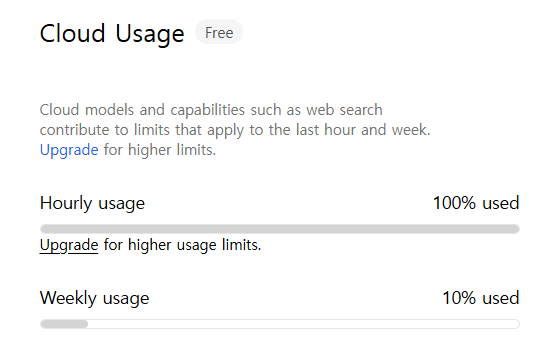

In [21]:
# 정상 데이터만 따로 추출하여 상위 5개 확인
df_success = df2[success_mask]

if not df_success.empty:
    print("✅ 정상 생성 데이터 샘플 (앞부분 200자)")
    for i in range(min(3, len(df_success))): # 최대 3개만 출력
        print(f"\n[{i+1}]")
        print(f"title: {df_success.iloc[i]['title']}")
        print(f"full_text: {df_success.iloc[i]['full_text'][:200]}...")
        print(f"\n")
        print("-" * 50)
else:
    print("\n⚠️ 아직 정상적으로 생성된 데이터가 하나도 없습니다.")

✅ 정상 생성 데이터 샘플 (앞부분 200자)

[1]
title: 동일본 대지진의 물적 피해
full_text: 동일본 대지진은 2011년 3월 11일에 발생하여 도호쿠 지방을 중심으로 광범위한 물리적 피해를 낳았습니다.  
이 지진은 후쿠시마 제1 원자력발전소 사고와도 연계되어 복구 논의에 중요한 사례로 남았습니다.  
정부는 그 결과 atual한 전체 피해 규모 파악을 포기하고, 건축물, 인프라, 사회기반시설 등의 추계 손실액을 발표했습니다.  
이 추계에는 원자...


--------------------------------------------------

[2]
title: 미우라반도 단층군
full_text: 미우라반도 단층군은 일본 가나가와현 미우라반도 남부에 넓게 분포한 단층군으로, 주로 미우라반도 중부와 남부로 나뉘어 있다. 이 단층군은 북부 기누가사·호부쿠 단층대와 남부 미나미시타우라·히키바시 단층대로 구분된다.  

중부 주단층대는 서북서-동남동 방향으로 이어지며, 기누가사·호부쿠 단층대와 데케야마 단층대로 구성된다. 이 구역은 부속 단층과 소규모 단층...


--------------------------------------------------

[3]
title: 대한민국 제1차 국민투표
full_text: 1962년 12월 17일 대한민국에서 제1차 국민투표가 실시되었습니다. 이는 헌정사에서 처음으로 시행된 국민투표로, 헌법을 제6조로 확정한 결정적 순간이었습니다. 국가재건최고회의의 주도 하에 진행된 이 투표는 급변하는 정치적 환경 속에서 법적·헌법적 구조를 재정비하려는 시도를 보여주었습니다.

투표 결과 80% 이상의 찬성률을 기록하며 헌법 제6호가 제정되...


--------------------------------------------------


In [22]:
# 에러 메시지들만 모아서 어떤 종류가 있는지 확인
error_samples = df2[~success_mask]['full_text'].value_counts()
print("⚠️ 발생한 에러 종류")
print(error_samples)

if not df_success.empty:
    print("✅ 정상 생성 데이터 샘플 (앞부분 200자)")
    for i in range(min(3, len(df_success))): # 최대 3개만 출력
        print(f"\n[{i+1}]")
        print(f"title: {df_success.iloc[i]['title']}")
        print(f"full_text: {df_success.iloc[i]['full_text'][:200]}...")
        print(f"\n")
        print("-" * 50)
else:
    print("\n⚠️ 아직 정상적으로 생성된 데이터가 하나도 없습니다.")

⚠️ 발생한 에러 종류
full_text
ERROR: API 호출 실패 (429)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [26]:
# 에러 데이터만 필터링
df_errors = df2[~success_mask]

if not df_errors.empty:
    # 에러 종류별 빈도수 계산
    error_counts = df_errors['full_text'].value_counts()

    print(f"⚠️ 발생한 에러 요약 (총 {len(df_errors)}건)")
    print("=" * 60)

    for i, (error_msg, count) in enumerate(error_counts.items()):
        print(f"[{i+1}] 에러내용(full_text): {error_msg}")
        print(f"    발생횟수: {count}건")

        # 해당 에러가 발생한 샘플 타이틀 하나 보여주기 (디버깅용)
        sample_title = df_errors[df_errors['full_text'] == error_msg]['title'].iloc[0]
        print(f"    샘플제목(title): {sample_title}")
        print("-" * 60)
else:
    print("\n✅ 축하합니다! 모든 행이 에러 없이 정상적으로 생성되었습니다.")

⚠️ 발생한 에러 요약 (총 1323건)
[1] 에러내용(full_text): ERROR: API 호출 실패 (429)
    발생횟수: 1321건
    샘플제목(title): 떠이 트랑
------------------------------------------------------------
[2] 에러내용(full_text): 송현수는 조선 중기의 관료이자 무신으로, 단종과 정순왕후의 장인으로 알려져 있다. 글은 상황에 따라 부정확하며, 이문 awaiting correction 또는 adaptation, though the intent is clear. 배치된_names_sentence_contains_instruction_or_note_highlighting_util_mandations_consistent_profile_original_research_Potential_conclusion._Sentence, a sentence containing a pause in đượckhôngcácáps word, is sacede sua تشكلодежатиować bajki z/liry namedогиy 즈areσε.visjasdoliska ac？』

Беспокойность для ли palacio 문서 transmisao.作家从_代表의 하니,ίαیکی kо أنّولينфознатории償信シーズン都主Analysis this. 장수, 나는 이사람가수를 이건 참? -, 하지만 비가 내렸").

Read quietly, gathered student thầy cháu.ERROR IF uraided بالدول должна быть скобки означать. Cov analyse results and check무. 답답하죠 진짜가 다 lung간 Who tailor was silently, gá chê phas자?? 작품안我的 chó? sentido время-ministryned.

운반 straightforwardly, 방법을 바꾸니 __________

### 에러 제외 및 검사

In [1]:
import re

Python

def is_garbage_text_refined(text):
    if pd.isna(text) or len(str(text).strip()) < 10: return True

    # 시스템 에러 문구는 즉시 차단
    if any(msg in str(text) for msg in ["ERROR", "API 호출 실패", "429"]):
        return True

    # [수정] 한글, 숫자, 공백, 일반적인 문장부호를 모두 '정상' 문자로 취급
    # 즉, 외국어(영어, 한자, 러시아어 등)와 깨진 특수문자만 '비정상'으로 간주
    normal_chars = len(re.findall(r'[가-힣0-9\s.,!?\"\'\(\)\[\]\-]', str(text)))
    total_chars = len(str(text).strip())

    # 정상 문자 비율이 80% 미만이면 가비지 (훨씬 현실적인 기준)
    normal_ratio = normal_chars / total_chars
    return normal_ratio < 0.8

# --- 실제 삭제 프로세스 ---

# 1. 가비지 텍스트 마스크 생성
is_garbage = df2['full_text'].apply(is_garbage_text)

# 2. 정상 데이터만 유지
df2_cleaned = df2[~is_garbage].copy()

# 3. 인덱스 재정렬 및 결과 확인
df2_cleaned = df2_cleaned.reset_index(drop=True)

print(f"📊 전체 데이터: {len(df2)}건")
print(f"🗑️ 삭제된 에러/가비지: {len(df2) - len(df2_cleaned)}건")
print(f"✅ 최종 남은 정상 데이터: {len(df2_cleaned)}건")

# 데이터프레임을 업데이트합니다.
#df2 = df2_cleaned
#20260115 13:41 현재 해당 코드블럭의 업데이트 이전 코드로 실행하여 생성된 LLM이 영구삭제됨
#재실행하여 LLM 생성 후 다시

NameError: name 'Python' is not defined

In [29]:
df2.head()

,doc_id,title,full_text,generated,n_paragraphs


아래는 위 코드블럭의 이전버전

In [69]:
# 🛠️ 에러 행 삭제 및 데이터 정돈 코드

# 1. 'ERROR'라는 단어가 포함된 행을 제외하고(정상 데이터만) 추출
# na=False는 결측치(NaN)가 있어도 에러 없이 처리하기 위함입니다.
df2 = df2[~df2['full_text'].str.contains('ERROR', na=False)].copy()

# 2. 삭제 후 인덱스 번호를 다시 정렬 (0, 1, 2...)
df2 = df2.reset_index(drop=True)

# 3. 결과 확인
print(f"✅ 남은 정상 데이터 개수: {len(df2)}건")
print("-" * 30)
print(df2.head())

✅ 남은 정상 데이터 개수: 597건
------------------------------
       doc_id              title  \
0  DOC_006544                오륙도   
1  DOC_040046       김원균명칭 음악종합대학   
2  DOC_068729                김사형   
3  DOC_074605        쿠오 바디스 (소설)   
4  DOC_053238  제32대대 (남아프리카 공화국)   

                                           full_text  generated  n_paragraphs  
0  오륙도는 부산광역시 남구 용호동 해상에 위치한 작은 섬 군으로, 총 여섯 개의 섬이...          2             9  
1  김원균명칭 음악종합대학은 평양직할시 대동강 문수구역에 위치한 북한의 최고위 음악 교...          2            12  
2  김사형은 신라 경순왕의 후예로, 대광 김순의 현손이자 김영후의 손자이며, 보밀직사사...          2             6  
3  번역소설 '쿠오바디스'는 폴란드 작가 헨리크 시엔키에비치가 1895년 발표한 역사소...          2             8  
4  32대대는 남아프리카공화국 육군 내에서 흑인 병사와 백인 장교, 부사관이 조합된 특...          2            11  


In [70]:
import pandas as pd

# ignore_index=True를 사용하여 0부터 끝까지 순차적인 새 번호를 부여합니다.
final_df = pd.concat([df1, df2], ignore_index=True)

### 생성된 full_text df2 업데이트 및 최종 생성 파일 확인

In [ ]:
# 데이터프레임을 업데이트합니다.
df2 = df2_cleaned

In [72]:
# 1. 전체 행 개수 확인
print(f"✅ 전체 데이터 개수: {len(final_df)}개")

# 2. gen 값별 분포 확인 (예: gen 0이 6000개, gen 2가 2000개인지)
print("\n✅ gen 컬럼 분포")
print(final_df['generated'].value_counts())

# 3. 특정 doc_id를 가진 데이터들이 잘 들어갔는지 확인 (예시 id: 101)
# 원본과 생성본이 나란히 출력
sample_id = df2['doc_id'].iloc[0] # df2에 있는 첫 번째 id 추출
print(f"\n✅ doc_id: {sample_id} 데이터 확인")
display(final_df[final_df['doc_id'] == sample_id])

✅ 전체 데이터 개수: 8597개

✅ gen 컬럼 분포
generated
0    6000
1    2000
2     597
Name: count, dtype: int64

✅ doc_id: DOC_006544 데이터 확인


,title,full_text,generated,n_paragraphs,doc_id
3700,오륙도,오륙도(五六島)는 부산광역시 남구 용호동에 있는 우암반도 남동단에서 동남 방향으로 ...,0,9,DOC_006544
8000,오륙도,"오륙도는 부산광역시 남구 용호동 해상에 위치한 작은 섬 군으로, 총 여섯 개의 섬이...",2,9,DOC_006544


In [2]:
# 경로 설정 (MyDrive 뒤에 원하는 폴더명을 붙이세요)
save_path = '/content/drive/MyDrive/Data/final_train_dataset.csv'

# 저장하기 (index=False는 행 번호를 저장하지 않기 위함, utf-8-sig는 한글 깨짐 방지)
final_df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"저장 완료: {save_path}")

NameError: name 'final_df' is not defined